In [2]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from torch.utils.data import TensorDataset, DataLoader

# Data Preprocessing

In [3]:
data = pd.read_csv('train.csv', low_memory=False)
data.head()

stock_id  date_id  seconds_in_bucket  imbalance_size  \
0         0        0                  0      3180602.69   
1         1        0                  0       166603.91   
2         2        0                  0       302879.87   
3         3        0                  0     11917682.27   
4         4        0                  0       447549.96   

   imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                        1         0.999812   13380276.64        NaN   
1                       -1         0.999896    1642214.25        NaN   
2                       -1         0.999561    1819368.03        NaN   
3                       -1         1.000171   18389745.62        NaN   
4                       -1         0.999532   17860614.95        NaN   

   near_price  bid_price  bid_size  ask_price   ask_size  wap    target  \
0         NaN   0.999812  60651.50   1.000026    8493.03  1.0 -3.029704   
1         NaN   0.999896   3233.04   1.000660   20605.09  1.0 -5.519986   
2         NaN   0.999403  37956.00   1.000298   18995.00  1.0 -8.389950   
3         NaN   0.999999   2324.90   1.000214  479032.40  1.0 -4.010200   
4         NaN   0.999394  16485.54   1.000016     434.10  1.0 -7.349849   

   time_id row_id  
0        0  0_0_0  
1        0  0_0_1  
2        0  0_0_2  
3        0  0_0_3  
4        0  0_0_4

Dropping rows with missing values, columns with majority missing values and id columns. Then converting data to time series for each stock and date id.

In [4]:
data = data.dropna(subset=['wap'], axis=0)
data = data.sort_values(['date_id', 'stock_id', 'seconds_in_bucket'])
data = data.drop(['far_price', 'near_price', 'time_id', 'row_id',
                  'stock_id', 'date_id', 'seconds_in_bucket'], axis=1)

In [5]:
X = data.drop('target', axis=1)
Y = data['target']

columns = X.columns.values
TIME_STEPS = 55
FEATURES = X.shape[1]

X = X.values.reshape(-1, TIME_STEPS, FEATURES)
Y = Y.values.reshape(-1, TIME_STEPS)

Spliting data into train, validation and test sets and scaling input features.

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, random_state=3)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=3)

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, FEATURES)).reshape(-1, TIME_STEPS, FEATURES)
X_val = scaler.transform(X_val.reshape(-1, FEATURES)).reshape(-1, TIME_STEPS, FEATURES)
X_test = scaler.transform(X_test.reshape(-1, FEATURES)).reshape(-1, TIME_STEPS, FEATURES)

Removing noise from all input time series data.

In [8]:
def remove_noise(x, window_len):
  res = [np.mean(x[max(0, i-window_len):i], axis=0) for i in range(1, x.shape[0] + 1)]
  return np.array(res)

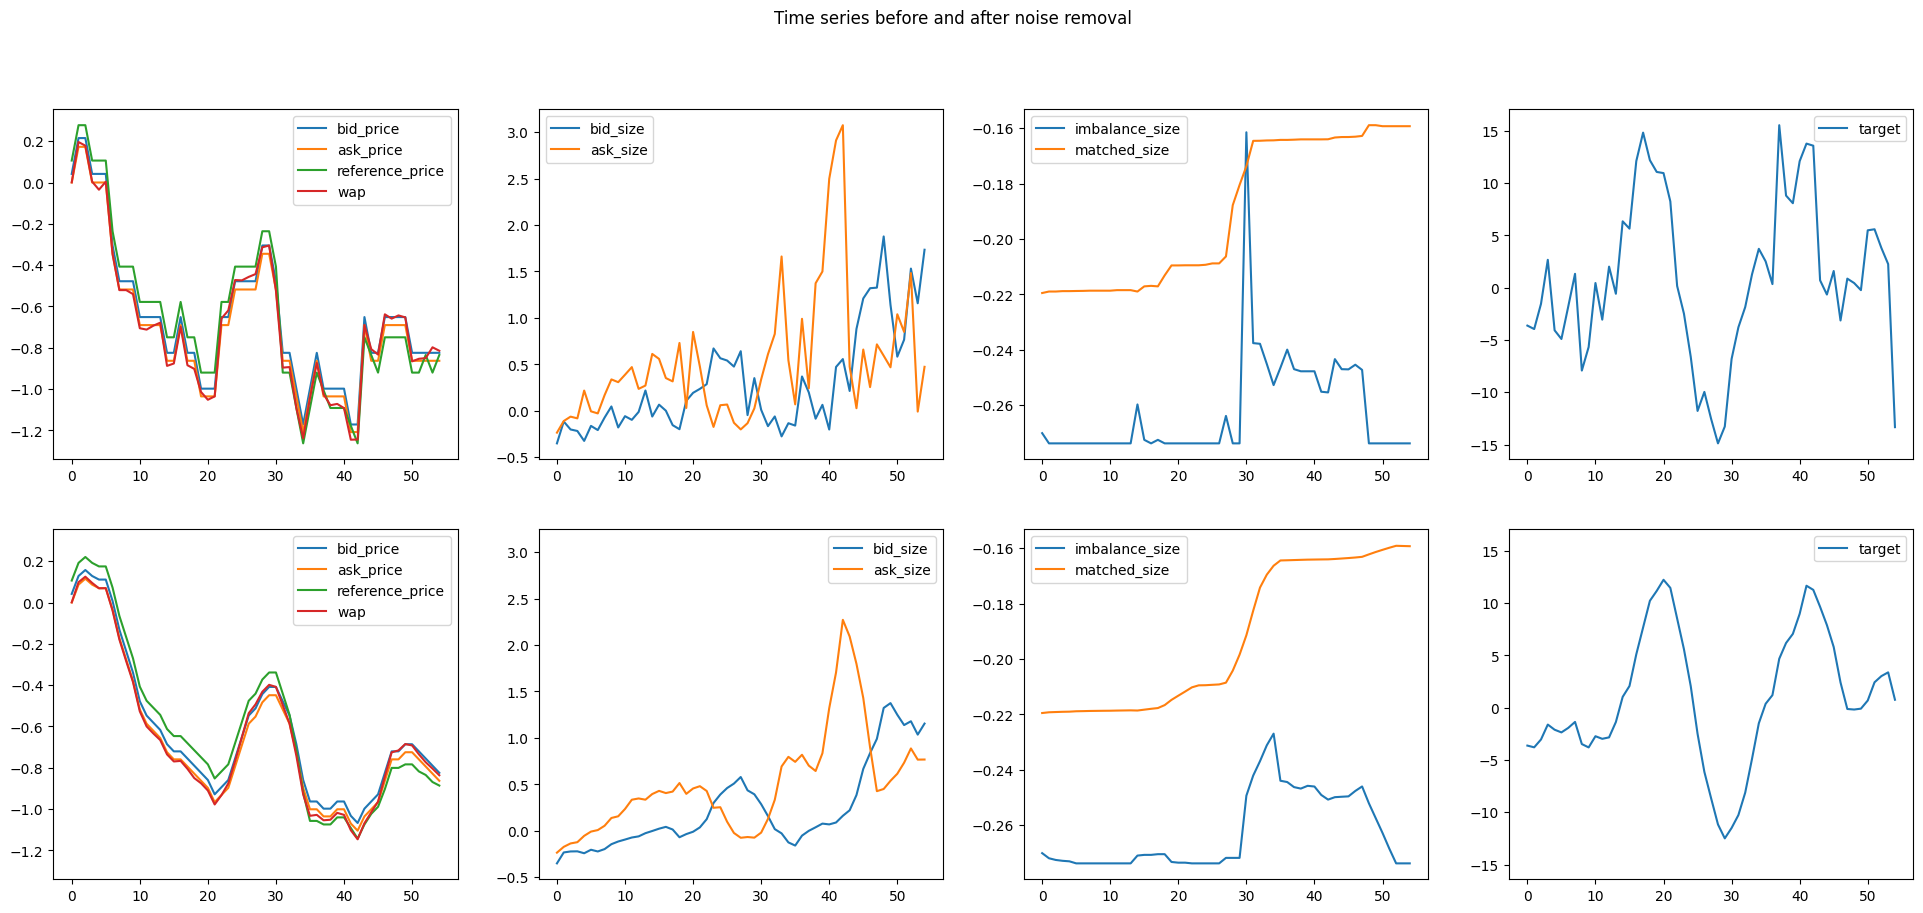

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(24, 10), sharey='col')
WINDOW_LEN = 5
print_index = 1
plot_series = X_train[print_index]
plot_target = y_train[print_index]

sns.lineplot(plot_series[:, 4], label=columns[4], ax=axs[0][0])
sns.lineplot(plot_series[:, 6], label=columns[6], ax=axs[0][0])
sns.lineplot(plot_series[:, 2], label=columns[2], ax=axs[0][0])
sns.lineplot(plot_series[:, 8], label=columns[8], ax=axs[0][0])

sns.lineplot(plot_series[:, 5], label=columns[5], ax=axs[0][1])
sns.lineplot(plot_series[:, 7], label=columns[7], ax=axs[0][1])

sns.lineplot(plot_series[:, 0], label=columns[0], ax=axs[0][2])
sns.lineplot(plot_series[:, 3], label=columns[3], ax=axs[0][2])

sns.lineplot(plot_target, label='target', ax=axs[0][3])

plot_series = remove_noise(plot_series, WINDOW_LEN)
plot_target = remove_noise(plot_target, WINDOW_LEN)

sns.lineplot(plot_series[:, 4], label=columns[4], ax=axs[1][0])
sns.lineplot(plot_series[:, 6], label=columns[6], ax=axs[1][0])
sns.lineplot(plot_series[:, 2], label=columns[2], ax=axs[1][0])
sns.lineplot(plot_series[:, 8], label=columns[8], ax=axs[1][0])

sns.lineplot(plot_series[:, 5], label=columns[5], ax=axs[1][1])
sns.lineplot(plot_series[:, 7], label=columns[7], ax=axs[1][1])

sns.lineplot(plot_series[:, 0], label=columns[0], ax=axs[1][2])
sns.lineplot(plot_series[:, 3], label=columns[3], ax=axs[1][2])

sns.lineplot(plot_target, label='target', ax=axs[1][3])
plt.suptitle('Time series before and after noise removal')
plt.show()

In [10]:
X_train_smooth = np.array([remove_noise(x, WINDOW_LEN) for x in X_train])
X_val_smooth = np.array([remove_noise(x, WINDOW_LEN) for x in X_val])
X_test_smooth = np.array([remove_noise(x, WINDOW_LEN) for x in X_test])

# Modeling

In [11]:
baseline_val_loss = mean_absolute_error(np.full(y_val.shape, 0), y_val)
baseline_test_loss = mean_absolute_error(np.full(y_test.shape, 0), y_test)

In [12]:
class LSTM(torch.nn.Module):
  def __init__(self, feature_num, hidden_size, num_layers=1, dropout_rate=0):
    super().__init__()
    self.hidden_size = hidden_size
    self.lstm = torch.nn.LSTM(input_size=feature_num,
                              hidden_size=hidden_size,
                              num_layers=num_layers,
                              dropout=dropout_rate,
                              batch_first=True)
    self.dropout = torch.nn.Dropout(p=dropout_rate)
    self.linear = torch.nn.Linear(in_features=hidden_size, out_features=1)

  def forward(self, x, lstm_state=None):
    time_steps = x.shape[0] if x.dim() == 2 else x.shape[1]

    if lstm_state is None:
      x, (h_n, c_n) = self.lstm(x)
    else:
      x, (h_n, c_n) = self.lstm(x, lstm_state)

    x = x.reshape(-1, self.hidden_size)
    x = self.dropout(x)
    x = self.linear(x)
    x = x.reshape(-1, time_steps)
    return x, (h_n, c_n)

In [13]:
class GRU(torch.nn.Module):
  def __init__(self, feature_num, hidden_size, num_layers=1, dropout_rate=0):
    super().__init__()
    self.hidden_size = hidden_size
    self.gru = torch.nn.GRU(input_size=feature_num,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            dropout=dropout_rate,
                            batch_first=True)
    self.dropout = torch.nn.Dropout(p=dropout_rate)
    self.linear = torch.nn.Linear(in_features=hidden_size, out_features=1)

  def forward(self, x, gru_state=None):
    time_steps = x.shape[0] if x.dim() == 2 else x.shape[1]

    if gru_state is None:
      x, h_n = self.gru(x)
    else:
      x, h_n = self.gru(x, gru_state)

    x = x.reshape(-1, self.hidden_size)
    x = self.dropout(x)
    x = self.linear(x)
    x = x.reshape(-1, time_steps)
    return x, h_n

In [14]:
def load_train_state(save_path, model=None, optimizer=None):
  train_state = torch.load(save_path, map_location=device)
  epoch = train_state['epoch']
  train_loss = train_state['train_loss']
  val_loss = train_state['val_loss']
  if model is not None:
    model.load_state_dict(train_state['model'])
  if optimizer is not None:
    optimizer.load_state_dict(train_state['optimizer'])
  return epoch, train_loss, val_loss

In [15]:
def train_model(model, criterion, optimizer, train_loader, val_loader, save_path, best_path, load=True):
  init_epoch = 0
  train_loss = []
  val_loss = []
  # Loading training progress if available
  if load and os.path.isfile(save_path):
    init_epoch, train_loss, val_loss = load_train_state(save_path, model, optimizer)
    init_epoch += 1

  model.train()
  best_val_loss = 100000 if len(val_loss) == 0 else np.min(val_loss)
  for epoch in range(init_epoch, EPOCH_NUM):
    print(f'EPOCH: {epoch + 1}')
    epoch_loss = 0

    # Iterating over training batches
    for i, (batch, target) in enumerate(iter(train_loader)):
      print(f'\rBatch [{i}/{len(train_loader)}]', end='')
      optimizer.zero_grad()

      output, _ = model(batch)
      loss = criterion(output, target)
      epoch_loss += loss.item()

      loss.backward()
      optimizer.step()

    epoch_loss /= len(train_loader)
    train_loss.append(epoch_loss)
    print(f'\rTrain MAE = {epoch_loss}')

    # Calculating validation loss
    model.eval()
    with torch.no_grad():
      epoch_val_loss = 0

      for batch, target in iter(val_loader):
        output, _ = model(batch)
        epoch_val_loss += criterion(output, target).item()

      epoch_val_loss /= len(val_loader)
      val_loss.append(epoch_val_loss)
      print(f'Validation MAE = {epoch_val_loss}')
    model.train()

    # Saving best model
    if epoch_val_loss < best_val_loss:
      best_val_loss = epoch_val_loss
      torch.save(model.state_dict(), best_path)

    # Saving training progress
    training_state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(),
                      'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss}
    torch.save(training_state, save_path)

  # Loading model with lowest loss on validation data
  model.load_state_dict(torch.load(best_path));

# Training

In [16]:
def print_loss(save_path):
  _, train_loss, val_loss = load_train_state(save_path)
  print(f'Best validation loss: {np.min(val_loss)}')
  sns.lineplot(train_loss, label='Train loss')
  sns.lineplot(val_loss, label='Validation loss')
  sns.lineplot(np.full(len(val_loss), baseline_val_loss),
             label='Baseline model validation loss', color='red')
  plt.show()

In [17]:
def make_loader(x: np.ndarray, y: np.ndarray, batch_size, shuffle):
  tx = torch.tensor(x.copy(), device=device, dtype=torch.float32)
  ty = torch.tensor(y.copy(), device=device, dtype=torch.float32)

  dataset = TensorDataset(tx, ty)
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
  return loader

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
display(device)

BATCH_SIZE = 64
VAL_BATCH_SIZE = 512
EPOCH_NUM = 100
LEARNING_RATE = 0.001

HIDDEN_SIZE = 256
LAYERS = 2
DROPOUT = 0.5
criterion = torch.nn.L1Loss(reduction='mean')

device(type='cuda', index=0)

In [19]:
train_loader = make_loader(X_train, y_train, BATCH_SIZE, shuffle=True)
val_loader = make_loader(X_val, y_val, VAL_BATCH_SIZE, shuffle=False)
model1 = LSTM(feature_num=FEATURES, hidden_size=HIDDEN_SIZE, num_layers=LAYERS, dropout_rate=DROPOUT)
model1 = model1.to(device=device, dtype=torch.float32)
optimizer = torch.optim.AdamW(model1.parameters(), lr=LEARNING_RATE)
save_path1 = 'models/model1.pt'
best_path1 = 'models/model1_best.pt'

In [20]:
train_model(model1, criterion, optimizer, train_loader, val_loader, save_path1, best_path1)

Best validation loss: 6.2841147316826715


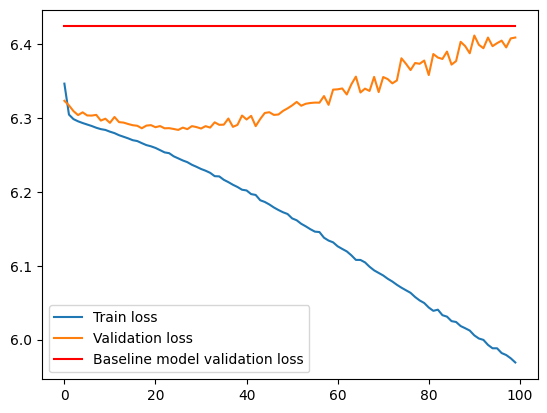

In [21]:
print_loss(save_path1)

In [22]:
train_loader = make_loader(X_train, y_train, BATCH_SIZE, shuffle=True)
val_loader = make_loader(X_val, y_val, VAL_BATCH_SIZE, shuffle=False)
model2 = GRU(feature_num=FEATURES, hidden_size=HIDDEN_SIZE, num_layers=LAYERS, dropout_rate=DROPOUT)
model2 = model2.to(device=device, dtype=torch.float32)
optimizer = torch.optim.AdamW(model2.parameters(), lr=LEARNING_RATE)
save_path2 = 'models/model2.pt'
best_path2 = 'models/model2_best.pt'

In [23]:
train_model(model2, criterion, optimizer, train_loader, val_loader, save_path2, best_path2)

Best validation loss: 6.287539137734307


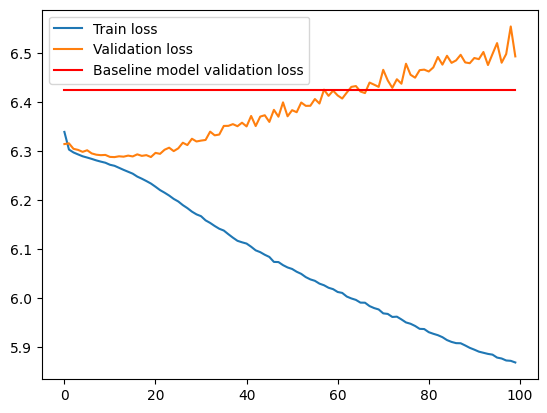

In [24]:
print_loss(save_path2)

In [25]:
train_loader = make_loader(X_train_smooth, y_train, BATCH_SIZE, shuffle=True)
val_loader = make_loader(X_val_smooth, y_val, VAL_BATCH_SIZE, shuffle=False)
model3 = LSTM(feature_num=FEATURES, hidden_size=HIDDEN_SIZE, num_layers=LAYERS, dropout_rate=DROPOUT)
model3 = model3.to(device=device, dtype=torch.float32)
optimizer = torch.optim.AdamW(model3.parameters(), lr=LEARNING_RATE)
save_path3 = 'models/model3.pt'
best_path3 = 'models/model3_best.pt'

In [26]:
train_model(model3, criterion, optimizer, train_loader, val_loader, save_path3, best_path3)

Best validation loss: 6.296937041812473


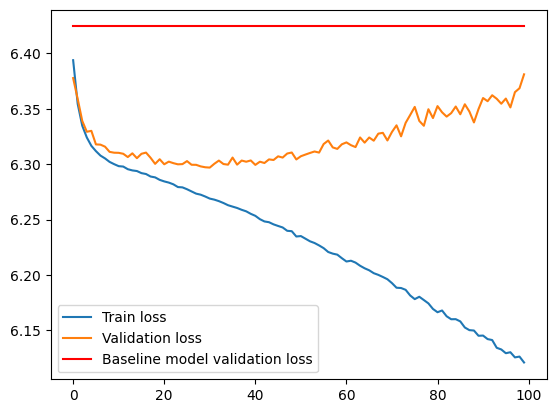

In [27]:
print_loss(save_path3)

In [28]:
train_loader = make_loader(X_train_smooth, y_train, BATCH_SIZE, shuffle=True)
val_loader = make_loader(X_val_smooth, y_val, VAL_BATCH_SIZE, shuffle=False)
model4 = GRU(feature_num=FEATURES, hidden_size=HIDDEN_SIZE, num_layers=LAYERS, dropout_rate=DROPOUT)
model4 = model4.to(device=device, dtype=torch.float32)
optimizer = torch.optim.AdamW(model4.parameters(), lr=LEARNING_RATE)
save_path4 = 'models/model4.pt'
best_path4 = 'models/model4_best.pt'

In [29]:
train_model(model4, criterion, optimizer, train_loader, val_loader, save_path4, best_path4)

Best validation loss: 6.296933465533787


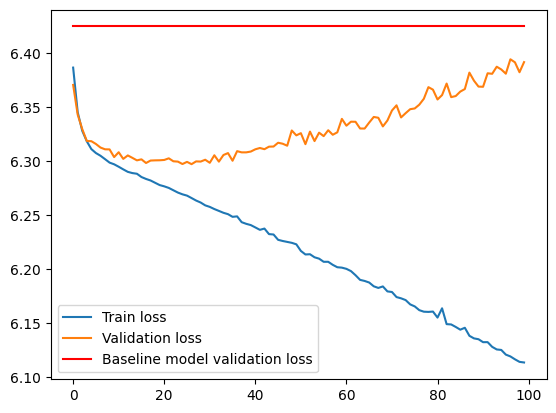

In [30]:
print_loss(save_path4)

# Prediction

In [31]:
print('Chosen model:')
model = model1
display(model.eval())

test_loader = make_loader(X_test, y_test, VAL_BATCH_SIZE, shuffle=False)
test_loss = 0
with torch.no_grad():
  for batch, target in iter(test_loader):
    output, _ = model(batch)
    test_loss += criterion(output, target).item()
  test_loss /= len(test_loader)

print(f'\nBaseline model test MAE: {baseline_test_loss}')
print(f'Chosen model test MAE: {test_loss}')

Chosen model:


LSTM(
  (lstm): LSTM(9, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)


Baseline model test MAE: 6.410732662459914
Chosen model test MAE: 6.282771931754218


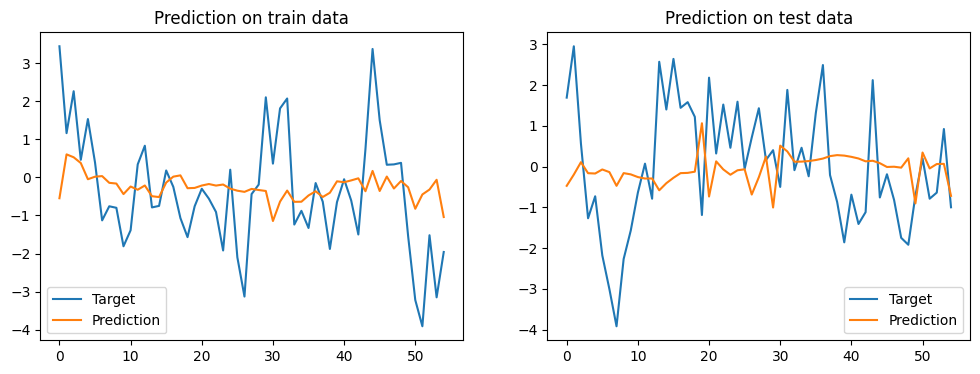

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_index1 = 50727
plot_index2 = 7446
train_series = torch.from_numpy(X_train[plot_index1]).to(device=device, dtype=torch.float32)
train_target = y_train[plot_index1]
test_series = torch.from_numpy(X_test[plot_index2]).to(device=device, dtype=torch.float32)
test_target = y_test[plot_index2]

train_pred, _ = model(train_series)
train_pred = train_pred.squeeze().cpu().detach().numpy()
sns.lineplot(train_target, label='Target', ax=ax1)
sns.lineplot(train_pred, label='Prediction', ax=ax1)
ax1.set_title('Prediction on train data')

test_pred, _ = model(test_series)
test_pred = test_pred.squeeze().cpu().detach().numpy()
sns.lineplot(test_target, label='Target', ax=ax2)
sns.lineplot(test_pred, label='Prediction', ax=ax2)
ax2.set_title('Prediction on test data')
plt.show()

In [33]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [34]:
network_states = {}
series_part = {}
time_step = 1
for test, revealed_targets, sample_prediction in iter_test:
  stock_ids = test['stock_id']

  # Starting new time series
  if test['seconds_in_bucket'].iloc[0] == 0:
    time_step = 1
    network_states.clear()
    series_part.clear()

  # Dropping columns, filling missing values, scaling data
  test = test.drop(['far_price', 'near_price', 'row_id', 'stock_id',
                    'date_id', 'seconds_in_bucket', 'currently_scored'], axis=1)
  test = test.fillna(0)
  test = scaler.transform(test.values)

  # Prediction
  prediction = []
  for id, point in zip(stock_ids, test):
    point = point.reshape(1, -1)
    point = torch.from_numpy(point).to(device=device, dtype=torch.float32)

    with torch.no_grad():
      if id not in network_states:
        network_states[id] = None
      output, new_state = model(point, network_states[id])
      network_states[id] = new_state
      prediction.append(output.squeeze().item())

  sample_prediction['target'] = prediction
  env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
